In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean

import json
from functools import partial
from typing import List

import re
import nltk

from nltk.corpus import stopwords

from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split
import gc
from sklearn import preprocessing

In [2]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
nltk.data.path.append("/usr/share/nltk_data")

In [4]:
!python3 -m nltk.downloader wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpor

### 2-B) EDA текста - можно ли предообработать текст, так чтобы он нес больше смысла для нашей задачи, возможно ли вытащить полезные фичи помимо расстояний между эмбеддингами (Проверка: добавление к базовому решению и сравнение с ним)

#### Мысли по поводу EDA текста
сначала:
- приведение к нижнему регистру (хотя вот насчет брендов не уверена, наверное их можно оставить с заглавными, чтобы потомь можно было выделить)
- удаление стоп-слов - союзы точно
- токенизация
- лемматизация

затем:
- пересечение общих лемм - коэф жаккара (???)
- длина названия
- ключевые слова - TextRank или RAKE
- мб извлечение числовых данных как отдельных признаков
- n-граммы слов
- мб бренд ??? - но он есть в колонке characteristic_attributes_mapping
- атрибуты типа цвета, веса, материала - хз нужны ли, цвет наверное можно отбросить, тк есть для этого отдельная колонка
- категории - опять же есть отдельная колонка
- 

In [5]:
dataset = pd.read_parquet('../input/lct-ozon/hackathon_files_for_participants_ozon/train_pairs.parquet')
etl = pd.read_parquet('../input/lct-ozon/hackathon_files_for_participants_ozon/train_data.parquet')

In [8]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [6]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [4]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


In [17]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [34]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_dimensions,name2_dimensions,name1_code,name2_code,name1_rus_abbreviations,name1_eng_abbreviations,name2_rus_abbreviations,name2_eng_abbreviations,name1_model,name2_model
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[1.5 м],[SQ1303-0138],[SQ1303-0136],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[3 м],[SQ1303-0138],[SQ1303-0137],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"


In [12]:
features[features['target'] == 1]

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
2,1.0,53062686,536165289,Картридж лазерный Комус 729 (4370B002) черный ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.0032773763, 0.32531193, -0.33156675, 0.41...","[-0.53706163, 0.37264067, 0.44363657, -0.37289...","{""Количество в упаковке, шт"":[""1""],""Бренд"":[""К...",Картридж лазерный Комус 729 (4368B002) пур. дл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[-0.043616347, 0.49310583, -0.3069673, 0.4820...","[-0.51572454, 0.40346462, 0.43528882, -0.34104...","{""Бренд"":[""Комус""],""Тип"":[""Картридж""]}"
3,1.0,53602615,587809782,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",Картридж лазерный Комус 729 (4370B002) чер. дл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.041107245, 0.48485547, -0.2837791, 0.4637...","[-0.5087511, 0.46164495, 0.42914906, -0.462508...","{""Тип"":[""Картридж""],""Бренд"":[""Нет бренда""]}"
4,1.0,53602615,615149925,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",Картридж лазерный Комус 729 (4368B002) пур. дл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[-0.043616347, 0.49310583, -0.3069673, 0.4820...","[-0.51572454, 0.40346462, 0.43528882, -0.34104...","{""Тип"":[""Картридж""],""Бренд"":[""Комус""]}"
5,1.0,53888651,89598677,Умные часы для детей S4,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...",[голубой],"[[0.680753, 0.09113727, 1.6140693, -0.04641545...","[[0.8777658, -0.42428812, 1.1310052, 0.4280405...","[-0.45303595, 0.35168907, 0.45074046, -0.29676...","{""Совместимость"":[""Android"",""PC"",""iOS""],""Матер...","Умные часы для детей S4, зеленый","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...","[голубой, зеленый]","[[0.48835745, 0.1087057, 1.6226497, 0.13992776...","[[0.6647656, -0.07456402, 1.2397044, 0.6757724...","[-0.43019646, 0.3099462, 0.45133576, -0.297509...","{""Размеры, мм"":[""45х39х14""],""Название цвета"":[..."
6,1.0,53888651,89581630,Умные часы для детей S4,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...",[голубой],"[[0.680753, 0.09113727, 1.6140693, -0.04641545...","[[0.8777658, -0.42428812, 1.1310052, 0.4280405...","[-0.45303595, 0.35168907, 0.45074046, -0.29676...","{""Совместимость"":[""Android"",""PC"",""iOS""],""Матер...",Умные часы для детей ACG S4,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...",[голубой],"[[0.29982805, 0.29919082, 1.2433035, 0.1025709...","[[0.49423033, -0.2179667, 1.1613696, 0.788193,...","[-0.43019646, 0.3099462, 0.45133576, -0.297509...","{""Работа в режиме ожидания, ч"":[""24""],""Дополни..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306515,1.0,773491488,788592731,"Умные часы IWO WearFit X6 Pro 44 мм женские, 4...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...","[светло-розовый, розовый]","[[-0.13852766, 0.16100964, 0.073471606, -0.010...","[[-0.30561784, 0.35826162, 0.08822195, -0.2377...","[-0.43421525, 0.60615, 0.37789795, -0.6671821,...","{""Технология матрицы"":[""TFT""],""Длина ремешка, ...","Умные часы Honor WearFit X6 Pro 44 мм женские,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"":

## EDA

### идеи:
- надо выделить бренды
- выделить аббревиатуры
- привести все 
- удалить сокращения цветов
- удалить цвета в принципе
- удалить слишком короткие слова
- выделить отдельно численные признаки
- выделить отдельно сущности в скобках

In [18]:
def change_dimensions(text):
    dimensions_change = {
        'cm ':'см', 'mm ':'мм', 'm ':'м', 'dm ':'дм',
        'A ':'А', 'Ампер ':'А', 'Ам ':'А', 'W ':'Вт ', 'V ':'В', 'Watt ':'Вт', 'Вольт ':'В', 'Ohm ':'Ом',
        'Gb ':'Гб', 'ГБ ':'Гб', 'Tb ':'Тб ', 'ТБ ':'Тб', 'Mb ':'Мб', 'МБ ':'Мб', 'Kb ':'Кб', 'КБ ':'Кб', 
        'byte ':'б', 'b ':'б', 'gb ':'Гб', 'kb ':'Кб', 'mb ':'Мб', 'tb ':'Тб',
        '"':'дюйм', 'inch ':'дюйм', 'inches ':'дюйм',
        'kg ':'кг', 'g ':'г', 'mg ':'мг',
        'hHz ':'гГц', 'hhz ':'гГц', 'gHz ':'ГГц', 'ghz ':'ГГц', 'kHz ':'кГц', 'khz ':'кГц', 'mHz ':'мГц', 'mhz ':'мГц', 'Hz ':'Гц', 'hz ':'Гц',
        'ч ':'час', 'min ':'минут', 'мин ':'минут', 'sec ':'секунд', 'сек ':'секунд', 'ms ':'милисекунд',
        'милисек ':'милисекунд', 'years ':'год', 'year ':'год', 'year ':'год', 'months ':'месяц', 'month ':'месяц'
    }
    text = re.sub(r'[,]',' ',text)
    for pattern, replacement in dimensions_change.items():
        text = re.sub(pattern, replacement, text)
    return text

In [19]:
features["name1_preprocessed"] = features.apply(lambda row: change_dimensions(row['name1']), axis=1)
features["name2_preprocessed"] = features.apply(lambda row: change_dimensions(row['name2']), axis=1)

In [20]:
def find_dimensions(text):
    dimensions_regex = r'\b(\d+(\.\d+)?)\s?(шт|см|мм|м|дм|А|Вт|В|Ом|Гб|Тб|Мб|Кб|байт|дюйм|кг|г|мг|гГц|ГГц|кГц|мГц|Гц|час|минут|секунд|милисекунд|год|месяц)\b'
    matches = re.findall(dimensions_regex, text)
    dimensions = [match[0] + ' ' + match[2] for match in matches]
    return dimensions

In [20]:
def del_dimensions(text):
    dimensions_regex = r'\b(\d+(\.\d+)?)\s?(шт|см|мм|м|дм|А|Вт|В|Ом|Гб|Тб|Мб|Кб|байт|дюйм|кг|г|мг|гГц|ГГц|кГц|мГц|Гц|час|минут|секунд|милисекунд|год|месяц)\b'
    text = re.sub(dimensions_regex, '', text)
    return text

In [21]:
features["name1_dimensions"] = features.apply(lambda row: find_dimensions(row['name1_preprocessed']), axis=1)
features["name2_dimensions"] = features.apply(lambda row: find_dimensions(row['name2_preprocessed']), axis=1)

In [22]:
features["name1_preprocessed"] = features.apply(lambda row: del_dimensions(row["name1_preprocessed"]), axis=1)
features["name2_preprocessed"] = features.apply(lambda row: del_dimensions(row["name1_preprocessed"]), axis=1)

In [33]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_dimensions,name2_dimensions,name1_code,name2_code,name1_rus_abbreviations,name1_eng_abbreviations,name2_rus_abbreviations,name2_eng_abbreviations,name1_model,name2_model
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[1.5 м],[SQ1303-0138],[SQ1303-0136],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[3 м],[SQ1303-0138],[SQ1303-0137],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"


In [22]:
def find_code(text):
    pattern = r'\b([A-Za-z0-9]*-*[A-Za-z0-9]+-[A-Za-z0-9]+)\b'
    code = re.findall(pattern, text)
    return code

def del_code(text):
    pattern = r'\b([A-Za-z0-9]*-*[A-Za-z0-9]+-[A-Za-z0-9]+)\b'
    text = re.sub(pattern, '', text)
    return text

In [24]:
features["name1_code"] = features.apply(lambda row: find_code(row['name1_preprocessed']), axis=1)
features["name2_code"] = features.apply(lambda row: find_code(row['name2_preprocessed']), axis=1)

In [29]:
features['name1_preprocessed'] = features.apply(lambda row: del_code(row['name1_preprocessed']), axis=1)
features['name1_preprocessed'] = features.apply(lambda row: del_code(row['name2_preprocessed']), axis=1)

In [25]:
def change_countr(text):
    countr_change = {
        'usd':'USD',
        'Usd':'USD',
        'eur':'USD',
        'Eur':'EUR',
        'Euro':'EUR',
        'EURO':'EUR',
        'euro':'EUR',
        'Uk':'UK',
        'uk':'UK',
        'Rus':'RUS',
        'rus':'RUS'
    }
    
    for pattern, replacement in countr_change.items():
        text = re.sub(pattern, replacement, text)
    return text

In [26]:
features["name1_preprocessed"] = features.apply(lambda row: change_countr(row['name1_preprocessed']), axis=1)
features["name2_preprocessed"] = features.apply(lambda row: change_countr(row['name2_preprocessed']), axis=1)

In [27]:
def find_countr(text):
    rule = r"\b(?:EUR|USD|RUS|UK|Китай|Япония)\b"
    countr = re.findall(rule, text)
    return countr

In [ ]:
# features["name1_countr"] = features.apply(lambda row: find_countr(row['name1_preprocessed']), axis=1)
# features["name2_preprocessed"] = features.apply(lambda row: find_countr(row['name2_preprocessed']), axis=1)

In [28]:
def find_rus_abbreviations(text):
    list_abr = []
    abbreviations = re.findall(r'\b[А-Я]{2,}\b', text)
    if abbreviations is not None:
        for abr in abbreviations:
            list_abr.append(str(abr))
    return list_abr
    

def find_eng_abbreviations(text):
    list_abr = []
    abbreviations = re.findall(r'\b[A-Z]{2,}\b', text)
    if abbreviations is not None:
        for abr in abbreviations:
            list_abr.append(str(abr))
    return list_abr

In [29]:
features["name1_rus_abbreviations"] = features.apply(lambda row: find_rus_abbreviations(row['name1_preprocessed']), axis=1)
features["name1_eng_abbreviations"] = features.apply(lambda row: find_eng_abbreviations(row['name1_preprocessed']), axis=1)

features["name2_rus_abbreviations"] = features.apply(lambda row: find_rus_abbreviations(row['name2_preprocessed']), axis=1)
features["name2_eng_abbreviations"] = features.apply(lambda row: find_eng_abbreviations(row['name2_preprocessed']), axis=1)

In [221]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_preprocessed,name2_preprocessed,name1_dimensions,name2_dimensions,name1_code,name2_code,name1_rus_abbreviations,name1_eng_abbreviations,name2_rus_abbreviations,name2_eng_abbreviations
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,[5 м],[1.5 м],[SQ1303-0138],[SQ1303-0136],[],[TDM],[],[TDM]
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,[5 м],[3 м],[SQ1303-0138],[SQ1303-0137],[],[TDM],[],[TDM]


In [30]:
def find_model(text):
    rule = r'\b(?=\w+\d)(?=\w*[a-zA-Zа-яА-Я])\w+[-]*\b(?<!-)'
    model = re.findall(rule, text)
    return model

In [35]:
features["name1_model"] = features.apply(lambda row: find_model(row['name1_preprocessed']), axis=1)
features["name2_model"] = features.apply(lambda row: find_model(row['name2_preprocessed']), axis=1)

In [36]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_dimensions,name2_dimensions,name1_code,name2_code,name1_rus_abbreviations,name1_eng_abbreviations,name2_rus_abbreviations,name2_eng_abbreviations,name1_model,name2_model
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[1.5 м],[SQ1303-0138],[SQ1303-0136],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,[5 м],[3 м],[SQ1303-0138],[SQ1303-0137],[],[TDM],[],[TDM],"[УЛ05В, SQ1303]","[УЛ05В, SQ1303]"


In [226]:
# def find_parenthesis_entities(text):
#     pattern = r'\[[^\[\]]+\]|\{[^{}]+\}|\([^()]+\)'  
#     entities = re.findall(pattern, text)
#     entities = re.sub(r'[({})]', '', str(entities))
#     return entities

# def find_num_entities(text):
#     num_rule = r'(?<![-\w])\b\d+(?:\.\d+)?\b(?![^\s-])'
#     numbers = re.findall(num_rule, text)
#     return numbers

# def find_num_alpha_entities(text):
#     rule = r'\b(?=\w*\d)(?=\w*[a-zA-Zа-яА-Я])\w+\b'
#     num_alpha = re.findall(rule, text)
#     return num_alpha

In [39]:
def abr_dot(text):
    return re.sub(r'\b\w+\.', '', text)

In [235]:
def define_brands():
    brands_list = []

    for item in etl["characteristic_attributes_mapping"]:
        if item is not None:
            attributes = json.loads(item)
        if "Бренд" in attributes and attributes["Бренд"] not in brands_list:
            brand = attributes["Бренд"]
            brands_list.append(brand)
    
    brands_list = [re.sub(r'\[|\]|\'', '', str(item)) for item in brands_list]
    
    return brands_list

def define_colors():
    color_list = []
    for item in etl["characteristic_attributes_mapping"]:
        if item is not None:
            attributes = json.loads(item)
        if "Цвет товара" in attributes:
            colors = attributes["Цвет товара"]
            for color in colors:
                if color not in color_list:
                    color_list.append(color)
    color_list = [re.sub(r'\[|\]|\'', '', str(item)) for item in color_list]
    
    return color_list

In [37]:
def text_preprocessing(text):
    ser = []
    num_del_rule = r'\b(?:\d+\w*|\w*\d+)\w*\b'
    spec_del_rule = r'[^a-zA-Zа-яА-Я0-9\s]'
    del_punkt_rule = r'[^\w\s]'
    
    text = text.lower() # приведение к нижнему регистру
    
    text = re.sub(num_del_rule, '', text) # удаление всех чисел
    text = re.sub(spec_del_rule, '', text) # удаление спец символов
    
    stop_words = ['для', 'в', 'с', 'под', 'и', 'или', 'на'] + list(stopwords.words('russian'))
    text = re.sub(del_punkt_rule, '', text) # удаление пунктуации

    tokens = nltk.word_tokenize(text) # токенизация 
    
    lemmatizer = WordNetLemmatizer() # лемматизируем текст
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words] # удаляем стоп-слова
    tokens = [word for word in tokens if len(word) > 1] # удаляем слова короче 2х символов
    
    
    preprocessed_text = ' '.join(tokens) # собираем обработанный текст обратно
    ser.append(preprocessed_text)
    ser.append(tokens)
    
    return ser

In [39]:
def create_tokens(text):
    ser = []
    del_punkt_rule = r'[^\w\s]'
    
    text = text.lower() # приведение к нижнему регистру
    
    stop_words = ['для', 'в', 'с', 'под', 'и', 'или', 'на'] + list(stopwords.words('russian'))
    text = re.sub(del_punkt_rule, '', text) # удаление пунктуации

    tokens = nltk.word_tokenize(text) # токенизация 
    
    lemmatizer = WordNetLemmatizer() # лемматизируем текст
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words] # удаляем стоп-слова
    tokens = [word for word in tokens if len(word) > 1] # удаляем слова короче 2х символов
    
    ser.append(tokens)
    
    return ser

In [ ]:
features[["tokens1"]]= (
    features[["name1"]].apply(
        lambda x: pd.Series(create_tokens(*x)), axis=1
    )
)

features[["tokens2"]] = (
    features[["name2"]].apply(
        lambda x: pd.Series(create_tokens(*x)), axis=1
    )
)

In [40]:
features[["name1_full_preprocessed", "name1_tokens"]] = (
    features[["name1"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

features[["name2_full_preprocessed", "name2_tokens"]] = (
    features[["name2"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

In [68]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name_model_similarity,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped,tokens1,tokens2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,1.0,-1.0,-1.0,-1.0,0.338458,0.003606,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители","[удлинитель, tdm, electric, люкс, ул05в, sq130...","[удлинитель, tdm, electric, люкс, ул05в, 15, s..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,1.0,-1.0,-1.0,-1.0,0.475419,0.007311,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители","[удлинитель, tdm, electric, люкс, ул05в, sq130...","[удлинитель, tdm, electric, люкс, ул05в, sq130..."


In [239]:
# def delete_colors(text):
#     colors_list = define_colors()
#     pattern = r"\b(" + "|".join(colors_list) + r")\b"
#     text = re.sub(pattern, "", text, flags=re.IGNORECASE)
#     return text

In [ ]:
# features["name1_full_preprocessed"] = features.apply(lambda row: delete_colors(row["name1_full_preprocessed"]), axis=1)
# features["name2_full_preprocessed"] = features.apply(lambda row: delete_colors(row["name2_full_preprocessed"]), axis=1)

In [43]:
def jaccard_similarity(list1, list2):
    if len(list1) == 0 and len(list2) == 0:
        return 1
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    if union != 0:
        return float(intersection) / union
    else:
        return 0

In [44]:
features['name_tokens_jaccard'] = features.apply(lambda row: jaccard_similarity(row['name1_tokens'], row['name2_tokens']), axis=1)
features['name_dimensions_similarity'] = features.apply(lambda row: jaccard_similarity(row['name1_dimensions'], row['name2_dimensions']), axis=1)
features['name_code_similarity'] = features.apply(lambda row: jaccard_similarity(row['name1_code'], row['name2_code']), axis=1)

features['name_rus_abbreviations_similarity'] = features.apply(lambda row: jaccard_similarity(row['name1_rus_abbreviations'], 
                                                                                              row['name2_rus_abbreviations']), axis=1)

features['name_eng_abbreviations_similarity'] = features.apply(lambda row: jaccard_similarity(row['name1_eng_abbreviations'], 
                                                                                              row['name2_eng_abbreviations']), axis=1)

features['name_model_similarity'] = features.apply(lambda row: jaccard_similarity(row['name1_model'], row['name2_model']), axis=1)

In [70]:
features['lemmas_similarity'] = features.apply(lambda row: jaccard_similarity(row['tokens1'], row['tokens2']), axis=1)

In [46]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_full_preprocessed,name1_tokens,name2_full_preprocessed,name2_tokens,name_tokens_jaccard,name_dimensions_similarity,name_code_similarity,name_rus_abbreviations_similarity,name_eng_abbreviations_similarity,name_model_similarity
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]",удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]",1.0,0.0,1.0,0.0,1.0,1.0
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]",удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]",1.0,0.0,1.0,0.0,1.0,1.0


In [69]:
# def find_brand_in_name(text):
#     text = text[0].lower() + text[1:]
#     brand_rule = r'"([^"]*)"'
#     brands_list = define_brands()
#     name_brand = []
    
#     brand = re.search(r"([A-Za-z]+)\s", text)
#     if brand is not None:
#         name_brand.append(brand)
#     br = re.search(brand_rule, text)
#     if br is not None:
#         br = re.sub(r'\"', '', br)
#         name_brand.append(br)
#     br = re.match(r"([A-Za-z]+)", text)
#     if br is not None:
#         name_brand.append(br)
#     return name_brand

In [ ]:
# def brand_finding(text):
#     brand_rule = r'"([^"]*)"'
#     brand = re.search(r"([A-Za-z]+)\s", product_name).group(1)
#     brands_list = []

#     for item in etl["characteristic_attributes_mapping"]:
#         if item is not None:
#             attributes = json.loads(item)
#         if "Бренд" in attributes and attributes["Бренд"] not in brands_list:
#             brand = attributes["Бренд"]
#             brands_list.append(brand)
    
#     brands_list = [re.sub(r'\[|\]|\'', '', str(item)) for item in brands_list]
    
#     br = re.search(r"([A-Za-z]+)\s", text)
#     br = re.sub(r'\"|\'', '', str(br))
    
#     if br is not None or 

In [123]:
def make_tfidf(data):
    vectorizer = TfidfVectorizer()
    vectorized_text = vectorizer.fit_transform(data)
    vectorized_text = vectorized_text.toarray()
    return vectorized_text

In [ ]:
# vectorizer = TfidfVectorizer(max_df=)
# vectorized_text = vectorizer.fit_transform(features["name1_full_preprocessed"].values)
# vectorized_text = vectorized_text.toarray()

In [ ]:
# features[["name1_tfidf"]] = (
#     features[["name1"]].apply(
#         lambda x: pd.Series(make_tfidf(*x)), axis=1
#     )
# )

# features[["name2_tfidf"]] = (
#     features[["name2"]].apply(
#         lambda x: pd.Series(make_tfidf(*x)), axis=1
#     )
# )

In [141]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:50]


def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    top_n_bigrams=get_top_ngram(text,n)[:50]
    x,y=map(list,zip(*top_n_bigrams))
    plt.subplots(figsize=(30, 30))
    sns.barplot(x=y,y=x)

In [ ]:
# plot_top_ngrams_barchart(features['name1_preproc'],1)

In [45]:
def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features

def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


In [46]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [47]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

In [48]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [51]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name_dimensions_similarity,name_code_similarity,name_rus_abbreviations_similarity,name_eng_abbreviations_similarity,name_model_similarity,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.0,1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,0.338458,0.003606
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.0,1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,0.475419,0.007311


In [49]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

In [50]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

In [51]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

## Modeling

In [106]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist", 
       'name_dimensions_similarity', 'name_code_similarity', 
        'name_eng_abbreviations_similarity', 'name_tokens_jaccard', 'name_model_similarity']

In [107]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

In [108]:
model = CatBoostClassifier()

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model.save_model(f"../working/changed_baseline.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6670403	test: 0.6662936	best: 0.6662936 (0)	total: 33.8ms	remaining: 33.7s


100:	learn: 0.5167080	test: 0.5127475	best: 0.5127475 (100)	total: 3.21s	remaining: 28.6s
200:	learn: 0.5038616	test: 0.5019608	best: 0.5019608 (200)	total: 6.42s	remaining: 25.5s
300:	learn: 0.4962606	test: 0.4968749	best: 0.4968749 (300)	total: 9.67s	remaining: 22.5s
400:	learn: 0.4907975	test: 0.4938174	best: 0.4938174 (400)	total: 12.9s	remaining: 19.3s
500:	learn: 0.4858775	test: 0.4909971	best: 0.4909971 (500)	total: 16.1s	remaining: 16.1s
600:	learn: 0.4817318	test: 0.4891850	best: 0.4891798 (599)	total: 19.3s	remaining: 12.8s
700:	learn: 0.4782344	test: 0.4882425	best: 0.4882425 (700)	total: 22.3s	remaining: 9.52s
800:	learn: 0.4750313	test: 0.4874380	best: 0.4874355 (798)	total: 25.5s	remaining: 6.33s
900:	learn: 0.4718667	test: 0.4862886	best: 0.4862798 (896)	total: 28.9s	remaining: 3.17s
999:	learn: 0.4690529	test: 0.4855751	best: 0.4855751 (999)	total: 32s	remaining: 0us

bestTest = 0.4855750805
bestIteration = 999



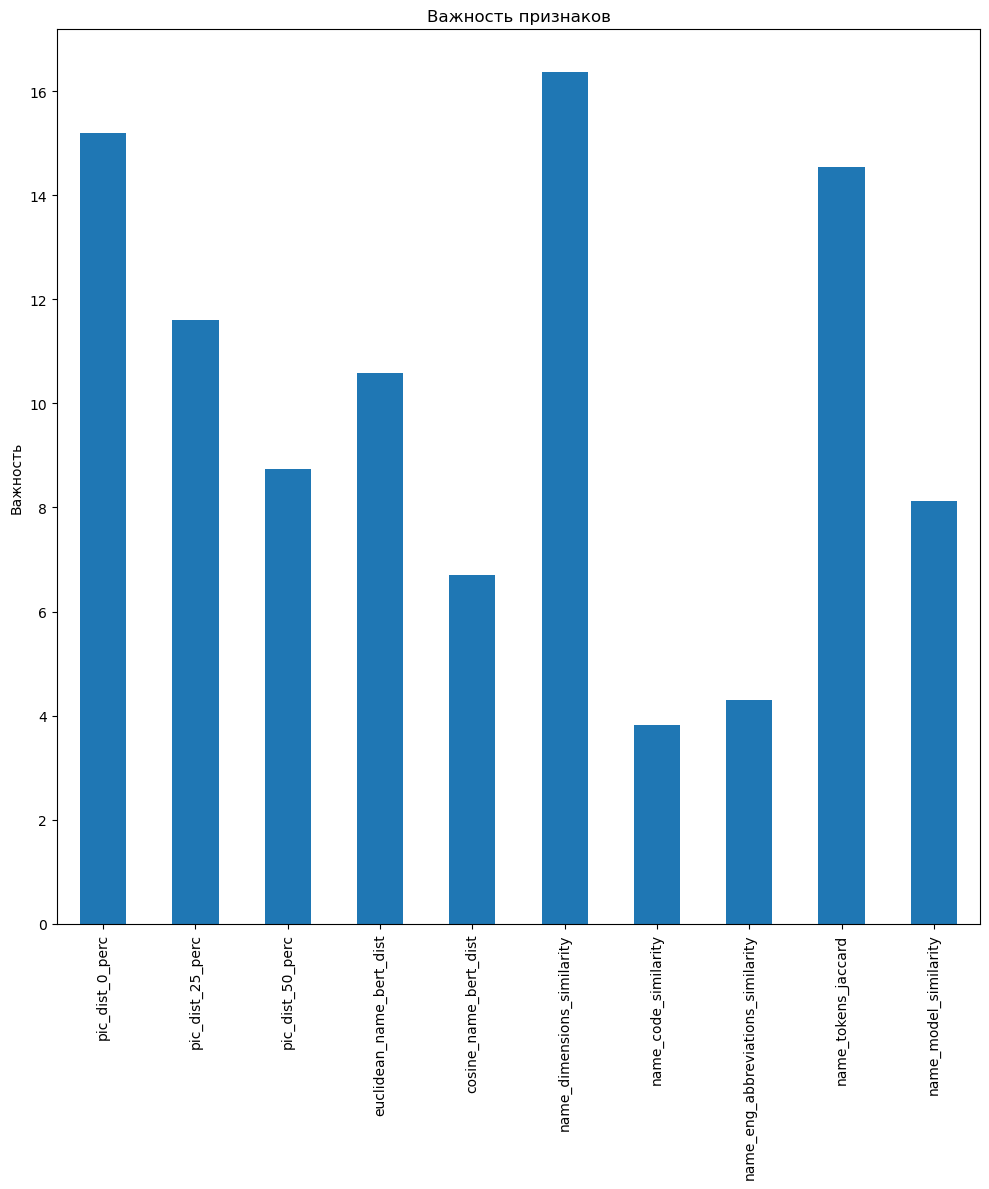

In [109]:
cb_imp = pd.Series(model.feature_importances_,
                         features[feats].columns)
fig, ax = plt.subplots(figsize=(10,12))
cb_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## Metric

In [110]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)


In [111]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [137]:
X_test.head(2)

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist,name_dimensions_similarity,name_code_similarity,name_eng_abbreviations_similarity,name_tokens_jaccard,name_model_similarity,variantid1,variantid2,cat3_grouped,scores
305957,-1.000000,-1.000000,-1.00000,0.284204,0.002250,1.0,1.0,0.0,0.428571,1.0,506029509,759875352,Батарейки и аккумуляторы,0.749815
221201,1.102281,3.954101,6.46823,0.330778,0.002966,1.0,0.0,0.5,0.666667,0.0,631006367,634594177,Видеокарты и графические ускорители,0.519217


In [150]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.3693450353268519

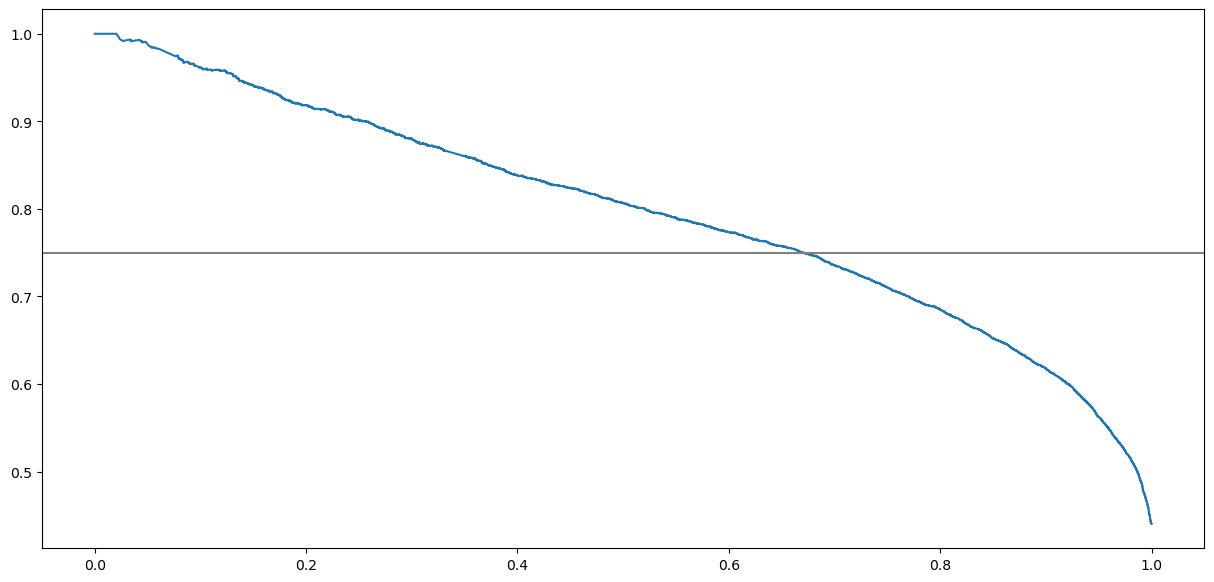

In [151]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

## Submission

In [116]:
test_pairs = pd.read_parquet("../input/lct-ozon/hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("../input/lct-ozon/hackathon_files_for_participants_ozon/test_data.parquet")

In [117]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [118]:
test_features["name1_preprocessed"] = test_features.apply(lambda row: change_dimensions(row['name1']), axis=1)
test_features["name2_preprocessed"] = test_features.apply(lambda row: change_dimensions(row['name2']), axis=1)

In [119]:
test_features["name1_dimensions"] = test_features.apply(lambda row: find_dimensions(row['name1_preprocessed']), axis=1)
test_features["name2_dimensions"] = test_features.apply(lambda row: find_dimensions(row['name2_preprocessed']), axis=1)

In [120]:
test_features["name1_code"] = test_features.apply(lambda row: find_code(row['name1_preprocessed']), axis=1)
test_features["name2_code"] = test_features.apply(lambda row: find_code(row['name2_preprocessed']), axis=1)

In [121]:
test_features["name1_preprocessed"] = test_features.apply(lambda row: change_countr(row['name1_preprocessed']), axis=1)
test_features["name2_preprocessed"] = test_features.apply(lambda row: change_countr(row['name2_preprocessed']), axis=1)

In [122]:
test_features["name1_eng_abbreviations"] = test_features.apply(lambda row: find_eng_abbreviations(row['name1_preprocessed']), axis=1)

test_features["name2_eng_abbreviations"] = test_features.apply(lambda row: find_eng_abbreviations(row['name2_preprocessed']), axis=1)

In [123]:
test_features["name1_model"] = test_features.apply(lambda row: find_model(row['name1_preprocessed']), axis=1)
test_features["name2_model"] = test_features.apply(lambda row: find_model(row['name2_preprocessed']), axis=1)

In [125]:
test_features[["name1_full_preprocessed", "name1_tokens"]] = (
    test_features[["name1"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

test_features[["name2_full_preprocessed", "name2_tokens"]] = (
    test_features[["name2"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

In [126]:
test_features['name_tokens_jaccard'] = test_features.apply(lambda row: jaccard_similarity(row['name1_tokens'], row['name2_tokens']), axis=1)
test_features['name_dimensions_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_dimensions'], row['name2_dimensions']), axis=1)
test_features['name_code_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_code'], row['name2_code']), axis=1)


test_features['name_eng_abbreviations_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_eng_abbreviations'], 
                                                                                              row['name2_eng_abbreviations']), axis=1)

test_features['name_model_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_model'], row['name2_model']), axis=1)

In [127]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [128]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [129]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [130]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")

In [152]:
test_features.head(2)

,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,...,name_code_similarity,name_eng_abbreviations_similarity,name_model_similarity,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped
0,52076340,290590137,Батарейка AAA щелочная Perfeo LR03/10BL Super ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.15417035, 0.41160947, 0.2213532, -0.019731...","[[0.04763528, -0.20136409, 0.29605597, 0.26453...","[-0.28437558, 0.60909724, 0.5972025, -0.523296...","{""Напряжение, В"":[""1.5""],""Бренд"":[""Perfeo""],""Т...",Батарейка AAA щелочная Perfeo LR03/2BL mini Su...,...,1.0,1.0,0.5,0.449950,0.449950,0.449950,0.719428,0.015745,Батарейки и аккумуляторы,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфон Ulefone Armor X5 3/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.239386, -0.8332473, -0.08384809, 0.071721...","[[-0.27325493, -0.6696304, 0.027148303, 0.0785...","[-0.45766184, 0.5528555, 0.26298037, -0.663931...","{""Операционная система"":[""Android""],""Защищенно...","Смартфон Ulefone Armor X3 2/32 ГБ, черный, кра...",...,1.0,1.0,0.0,3.567521,3.567521,3.567521,0.573571,0.009069,"Смартфоны, планшеты, мобильные телефоны","Смартфоны, планшеты, мобильные телефоны"


In [132]:
submission_test = test_features.copy()

In [138]:
submission_test["target"] = model.predict_proba(test_features[feats])[:, 1]

In [139]:
submission_test.head(2)

,variantid1,variantid2,scores,target
0,52076340,290590137,0.477636,0.477636
1,64525522,204128919,0.177769,0.177769


In [153]:
submission_test = submission_test[["variantid1", "variantid2", "target"]]

In [154]:
submission_test.head(2)

,variantid1,variantid2,target
0,52076340,290590137,0.477636
1,64525522,204128919,0.177769


In [156]:
submission_test.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission1.csv", index=False)